In [49]:
#Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import warnings
%matplotlib inline

In [2]:
df1 = pd.read_csv('training.1600000.processed.noemoticon.csv')
print(f'Shape of df1 : {df1.shape}')
df1.head()

Shape of df1 : (1048572, 6)


,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [4]:
df1.isna().sum()

polarity of tweet     0
id of the tweet       0
date of the tweet     0
query                 0
user                  0
text of the tweet     0
dtype: int64

No null data point in this dataset.

In [5]:
df1['polarity of tweet\xa0'].value_counts()

polarity of tweet 
0    799996
4    248576
Name: count, dtype: int64

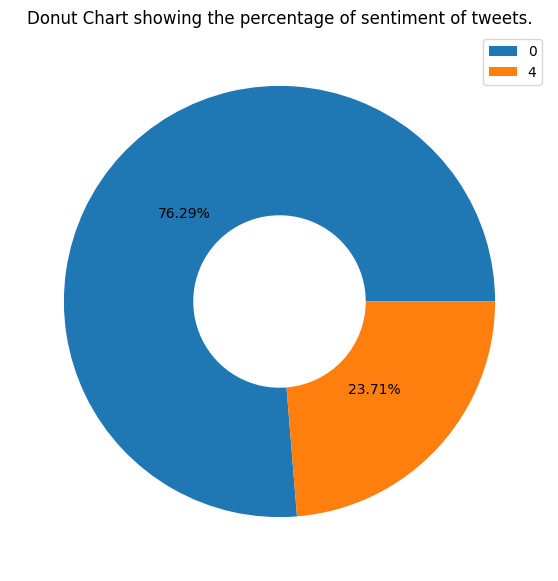

In [6]:
#Showing the above using Donut Plot
plt.figure(figsize=(7,7))
plt.pie(df1['polarity of tweet\xa0'].value_counts(), autopct="%1.2f%%", wedgeprops=dict(width=0.6))
#plt.legend(df1['polarity of tweet\xa0'].values)
plt.legend([0,4])
plt.title('Donut Chart showing the percentage of sentiment of tweets.')
plt.show()

In [7]:
df1['query'].value_counts()

query
NO_QUERY    1048572
Name: count, dtype: int64

The above output snippet says that the "query" column doesn't give us any additional information.

In [8]:
df1['date'] = pd.to_datetime(df1['date of the tweet'])

C:\Users\bvish\AppData\Local\Temp\ipykernel_14292\1184782893.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:49 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df1['date'] = pd.to_datetime(df1['date of the tweet'])


Now we have the date column in the format of datetime.

In [9]:
df1.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet,date
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,2009-04-06 22:20:00


Details about the date column

In [10]:
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.strftime('%b')

In [11]:
df1['year'].value_counts()

year
2009    1048572
Name: count, dtype: int64

The complete data is of the same year 2009

In [12]:
df1['month'].value_counts()

month
Jun    533571
May    414980
Apr    100021
Name: count, dtype: int64

A plot showing the percentage of tweets from each month

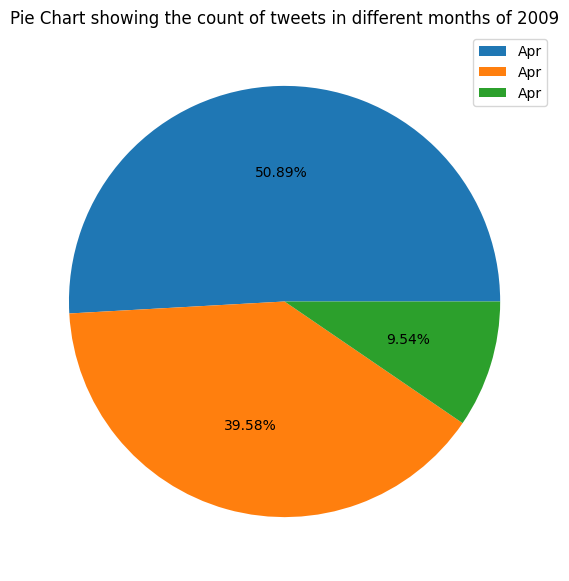

In [13]:
plt.figure(figsize=(7,7))
plt.pie(df1['month'].value_counts(), autopct="%1.2f%%")
plt.legend(df1['month'].values)
plt.title('Pie Chart showing the count of tweets in different months of 2009')
plt.show()

All the tweets belong to 2009's May, June and July months.
So, the year doesn't have any role and the Month might have!

User details : 

In [14]:
print('Number of unique users : ' , df1['user'].nunique())

Number of unique users :  511364


The tweets in this dataset wer received from more than half million users.

Shortening the text and removing all links and special characters(if any) from the text.

In [15]:
#Importing regular expression library
import re
import nltk
from nltk.corpus import stopwords   #Stopwords are the words which are less meaningfull for analyzing the text. These words occur more regularly.
from nltk.stem.porter import PorterStemmer    #This is useful for stemming, means removing the precedding and succeding parts of a word, like this gives us the root word
# # example : erasing -> erase

stemmer = PorterStemmer()

#Let's make a function and then apply it to the column

def review(text):
    #First we will remove the links from the text
    text_without_link = re.sub(r'http\S+', '', text)

    #Now we will remove special characteristics.
    reviewed = re.sub('[^a-zA-Z0-9]',' ',text_without_link) 
    #converting all alphabets into lower case, then removing the spaces preceeding and succeeding a complete sentence.
    reviewed = reviewed.lower().strip().split()  
    #excluding the stopwords
    reviewed = [stemmer.stem(i) for i in reviewed if not i in stopwords.words('english')]
    #joining the swords
    reviewed = ' '.join(reviewed)
    
    return reviewed

Run the below codes if you want to apply the review function to this large dataset.

In [16]:
#df1['selected_text'] = df1['text of the tweet\xa0'].apply(review)

In [20]:
# df1['text'] = df1['user'].str.lower() + " " + df1['month'].str.lower() + " " + df1['selected_text']

# df1.drop(['id of the tweet', 'date of the tweet','query','user','date','year','month', 'text of the tweet\xa0'],axis=1, inplace=True)

In [19]:
#I will convert this dataset into a csv file, because the dataset is too large it took huge amoutn of time to convert te data, 
#so I will save this dataset in a seperate dataset and then I will work on the data

# df1.to_csv('new_test.csv',header=True,index=False)

After running the above code, I made a new csv file "new_test.csv" which contains three columns : polarity of the tweet, selected text which is made using the above code and the third column is an additon of selected text, user name and month column.

Now dealing with "new_test.csv" file

In [18]:
df2 = pd.read_csv('new_test.csv')
print(f'\n\nSHape of the dataset : {df2.shape}')
df2.head()



SHape of the dataset : (1048572, 3)


,polarity of tweet,selected_text,text
0,0,upset updat facebook text might cri result sch...,scotthamilton apr upset updat facebook text mi...
1,0,kenichan dive mani time ball manag save 50 res...,mattycus apr kenichan dive mani time ball mana...
2,0,whole bodi feel itchi like fire,ellectf apr whole bodi feel itchi like fire
3,0,nationwideclass behav mad see,karoli apr nationwideclass behav mad see
4,0,kwesidei whole crew,joy_wolf apr kwesidei whole crew


Finding the most common words in the text column (Mostly the months names will be high in number)

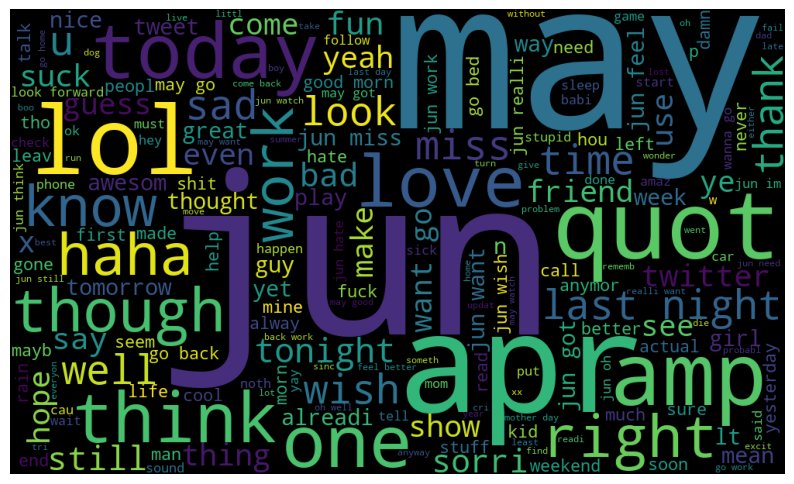

In [21]:
#word block

single_text = " ".join(df2['text'])

cloud = WordCloud(width=1000, height=600).generate(single_text)
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis('off')    #to hide the axis of the wordcloud
plt.show()


Considering only the columns required for model training.

In [22]:
x = df2['text'].values
y = df2['polarity of tweet\xa0'].values

In [23]:
#Vectorize the words
vector = TfidfVectorizer()

vector.fit(x)
x_vectors = vector.transform(x)

In [24]:
print(x_vectors.shape)

(1048572, 843855)


In [25]:
#Splitting into training and validation parts

x_train,x_val,y_train,y_val = train_test_split(x_vectors, y, train_size=0.8, stratify=y)

Working with the test data

In [27]:
df3 = pd.read_csv('testdata.manual.2009.06.14.csv',header=None)
df3.columns = ['polarity', 'Unknown','time','account','user', 'text']
df3.shape

(516, 6)

In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  516 non-null    int64 
 1   Unknown   516 non-null    int64 
 2   time      516 non-null    object
 3   account   516 non-null    object
 4   user      516 non-null    object
 5   text      516 non-null    object
dtypes: int64(2), object(4)
memory usage: 24.3+ KB


No null appearances in this dataset

In [29]:
df3.describe(include='all')

,polarity,Unknown,time,account,user,text
count,516.000000,516.000000,516,516,516,516
unique,NaN,NaN,498,85,494,498
top,NaN,NaN,Mon May 11 05:22:03 UTC 2009,time warner,vmkobs,"@sketchbug Lebron is a hometown hero to me, lo..."
freq,NaN,NaN,4,35,3,4
mean,2.077519,2293.281008,NaN,NaN,NaN,NaN
std,1.707152,3575.973001,NaN,NaN,NaN,NaN
min,0.000000,3.000000,NaN,NaN,NaN,NaN
25%,0.000000,392.750000,NaN,NaN,NaN,NaN
50%,2.000000,1022.500000,NaN,NaN,NaN,NaN
75%,4.000000,2380.250000,NaN,NaN,NaN,NaN


In [37]:
df3.head(5)

,polarity,Unknown,time,account,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


Let us repeat the same format as done for the training set

In [32]:
df3['polarity'].value_counts()

polarity
4    198
0    178
2    140
Name: count, dtype: int64

The dataset is quite well balanced.

In [33]:
df3['account'].value_counts()

account
time warner              35
nike                     25
"night at the museum"    25
gm                       22
kindle2                  20
                         ..
espn                      1
yahoo                     1
scrapbooking              1
republican                1
wieden                    1
Name: count, Length: 85, dtype: int64

In [34]:
df3['user'].value_counts()

user
vmkobs            3
emceet            3
peterlikewhat     3
theviewfans       2
cfbloggers        2
                 ..
jeffreymodest     1
sorayabouby       1
cmonaussiecmon    1
giz2000           1
emceett           1
Name: count, Length: 494, dtype: int64

In [38]:
df3['selected_text'] = df3['text'].apply(review)

In [40]:
df3.head(1)

,polarity,Unknown,time,account,user,text,selected_text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvvee kindle2 dx cool ...


In [41]:
df3['combined'] = df3['account'].str.lower() + " " + df3['user'].str.lower() +" " + df3['selected_text']

In [42]:
xtesting = df3['combined'].values
ytesting = df3['polarity'].values

In [43]:
xtest_vec = vector.transform(xtesting)

In [45]:
print(xtest_vec.shape)

(516, 843855)


Now I will build ml models

#Logistic Regression Model


In [46]:
lr = LogisticRegression(solver='saga')

In [47]:
lr.fit(x_train,y_train)

LogisticRegression(solver='saga')

In [51]:
solvers = ['liblinear', 'newton-cg', 'saga']

for i in solvers:
    print(f"Logistic Regression Model with solver {i}")
    lr = LogisticRegression(solver=i,max_iter=200)
    lr.fit(x_train,y_train)

    xtrain_predict = lr.predict(x_train)
    xtrain_accuracy = accuracy_score(y_train,xtrain_predict)

    xval_predict = lr.predict(x_val)
    xval_accuracy = accuracy_score(y_val,xval_predict)

    xtest_predict = lr.predict(xtest_vec)
    xtest_accuracy = accuracy_score(ytesting,xtest_predict)

    print("Accuracy Score of predicted data : ", xtrain_accuracy)
    print("Accuracy Score of val data : ", xval_accuracy)
    print("Accuracy Score of test data : ", xtest_accuracy)
    print("----------------")

Logistic Regression Model with solver liblinear
Accuracy Score of predicted data :  0.9246808454837953
Accuracy Score of val data :  0.8922871516105191
Accuracy Score of test data :  0.5213178294573644
----------------
Logistic Regression Model with solver newton-cg
Accuracy Score of predicted data :  0.9247332978088041
Accuracy Score of val data :  0.8923491405002026
Accuracy Score of test data :  0.5232558139534884
----------------
Logistic Regression Model with solver saga
Accuracy Score of predicted data :  0.9247356820053955
Accuracy Score of val data :  0.8923491405002026
Accuracy Score of test data :  0.5232558139534884
----------------


Support Vector Machine

In [ ]:
kernels = ['rbf','linear','poly','sigmoid']

for i in kernels:
    print("Kernel : ", i)
    model = SVC(kernel=i)
    model.fit(x_train,y_train)
    
    #xtrain_pred = model.predict(x_train)
    #xtrain_acc = accuracy_score(y_train,xtrain_pred)

    xval_predict = model.predict(x_val)
    xval_acc = accuracy_score(y_val,xval_predict)

    xtest_predict = model.predict(xtest_vec)
    xtest_acc = accuracy_score(ytesting,xtest_predict)
    
    print("Accuracy Score of predicted data : ", xtrain_acc)
    print("Accuracy Score of val data : ", xval_acc)
    print("Accuracy Score of test data : ", xtest_acc)